# Notebook for network training
Runs on colab GPU with data stored on drive or alternatively on local ressources

Content:

*   Load packages, check for GPU, mount drive & defince path to data
*   functions for (pre)processing, input pipeline
*   functions to create model
*   Loading data, setting up model
*   Checking input examples
*   Model training
*   Checking output examples










In [1]:
######################################################################################################################
# script and functions to train MQNet
# requires access to data (and GPU)
######################################################################################################################
import glob
import random

from scipy.signal import stft, istft
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import gridspec
import time
import datetime

from sklearn.preprocessing import RobustScaler

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D,Conv2DTranspose, MaxPool2D,Concatenate, AveragePooling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [2]:
# check GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

Num GPUs Available:  1
Thu Oct  6 14:06:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                 

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6581919107750272139
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14444920832
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13759757053376789318
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [3]:
# Mount drive to access data
from google.colab import drive
drive.mount('/content/gdrive')
# !pip freeze >> /content/gdrive/MyDrive/requirements_colab.txt 

# define path to training data
# training
path_odd_sol_train = '/content/gdrive/MyDrive/ML_3C/Training/Odd_sol/'
path_even_sol_train = '/content/gdrive/MyDrive/ML_3C/Training/Even_sol/'

# test
path_odd_sol_test = '/content/gdrive/MyDrive/ML_3C/Test/Odd_sol/'
path_even_sol_test = '/content/gdrive/MyDrive/ML_3C/Test/Even_sol/'

# plot settings
plt.rcParams['figure.figsize'] = [16, 12]
plt.rcParams['font.size'] = 12

Mounted at /content/gdrive


## **Input pipeline**

Functions: 
*   normalize_percentile: normalise data
*   normalize_percentile_6c: normalise data (alternative)
*   map_func: helper function used in input_pipeline
*   input_pipeline: main function for loading and preparation of data as dataset

Others:

*   date_name: helper functions to get time stamp
*   add_sample_weights: compute weigth maps (optional)









In [4]:
def normalize_percentile(data,quantile_range=(25,75),unit_variance=False,limit=50,clipping='constant'):
  """
  Robust normalisation of samples  1-component data
  For data with outliers (w hard/soft clipping), seperately for real and imag.
  Input: data and optional arguments
  Output: normalised data
  Requires: sklearn Robustscaler 
  """  
  # get data
  data_real = data[:,:,0]  # real
  data_imag = data[:,:,1]  # imag
  # define scaler 
  scaler =  RobustScaler(unit_variance=unit_variance)
  # apply to data: first flatten and then reshape
  data_real_norm = scaler.fit_transform(np.expand_dims(data_real.flatten(),1)).reshape((256,256))
  data_imag_norm = scaler.fit_transform(np.expand_dims(data_imag.flatten(),1)).reshape((256,256))

  # clip high values: hard or soft clippping
  stretch = limit/200

  if clipping=='constant':  # hard clipping, all values > limit
    data_real_norm[data_real_norm>limit]=limit
    data_real_norm[data_real_norm<-limit]=-limit
    data_imag_norm[data_imag_norm>limit]=limit
    data_imag_norm[data_imag_norm<-limit]=-limit
  elif clipping=='tanh':  # soft clipping with tanh
    data_real_norm = np.tanh(stretch*data_real_norm)
    data_imag_norm = np.tanh(stretch*data_imag_norm)
  elif clipping=='sigmoid':  # soft clipping with sigmoid
    data_real_norm = (1/(1 + np.exp(-stretch*data_real_norm)))*2-1
    data_imag_norm = (1/(1 + np.exp(-stretch*data_imag_norm)))*2-1
  elif clipping=='arctan':  # soft clipping with arctan
    data_real_norm = 2/np.pi * np.arctan(stretch*data_real_norm)
    data_imag_norm = 2/np.pi * np.arctan(stretch*data_imag_norm)
  else:  # no clipping
    data_real_norm = data_real_norm
    data_imag_norm = data_imag_norm
  # combine real and imag
  data_return = np.zeros(data.shape)
  data_return[:,:,0] = data_real_norm
  data_return[:,:,1] = data_imag_norm

  return data_return


def normalize_percentile_6c(data_input,quantile_range=(25,75),unit_variance=False,limit=50,clipping='constant'):
  """
  Robust normalisation of samples  3-component data
  For data with outliers (clipped)
  Input: data and optional arguments
  Output: normalised data
  Requires: sklearn Robustscaler 
  """  
  scaler =  RobustScaler(unit_variance=unit_variance)
  data_output = scaler.fit_transform(np.expand_dims(data_input.flatten(),1)).reshape((256,256,6))

  data_output[data_output>limit]=limit
  data_output[data_output<-limit]=-limit

  return data_output


def map_func(feature_path, clip_val=50, channel_norm=True):
  """
  Mapping (numpy) function in input_pipeline: load data and normalise
  Input: path to sample, optional: clip_value (50), channel_norm (True) to normalise all channels together
  Output: loaded data
  """
  feature = dict(np.load(feature_path))  # load saved dict
  if channel_norm:
    # load component data and normalise, change data type
    noisy_signal_Z = normalize_percentile(feature['noisy_signal_Z'],limit=clip_val).astype('float32')
    noisy_signal_N = normalize_percentile(feature['noisy_signal_N'],limit=clip_val).astype('float32')
    noisy_signal_E = normalize_percentile(feature['noisy_signal_E'],limit=clip_val).astype('float32')
    # combine ZNE
    noisy_signal = np.concatenate((noisy_signal_Z,noisy_signal_N,noisy_signal_E),axis=-1)
  else: # normalise l all channels together
    noisy_signal = np.concatenate((feature['noisy_signal_Z'],feature['noisy_signal_N'],feature['noisy_signal_E']),axis=-1)
    noisy_signal = normalize_percentile_6c(noisy_signal,limit=clip_val).astype('float32')

  # load event mask, get noise mask
  # Z: load event mask, change values from promille to value in [0-1], compute noise mask
  mask_Z_temp = (feature['masks_Z_promille']/1000).astype('float32')  
  mask_Z = np.zeros([mask_Z_temp.shape[0], mask_Z_temp.shape[1], 2],dtype='float32')
  mask_Z[:, :, 0] = mask_Z_temp[:,:,0]
  mask_Z[:, :, 1] = 1 - mask_Z_temp[:,:,0]

  # N
  mask_N_temp = (feature['masks_N_promille']/1000).astype('float32')  
  mask_N = np.zeros([mask_N_temp.shape[0], mask_N_temp.shape[1], 2],dtype='float32')
  mask_N[:, :, 0] = mask_N_temp[:,:,0]
  mask_N[:, :, 1] = 1 - mask_N_temp[:,:,0]

  # E
  mask_E_temp = (feature['masks_E_promille']/1000).astype('float32')
  mask_E = np.zeros([mask_E_temp.shape[0], mask_E_temp.shape[1], 2],dtype='float32')
  mask_E[:, :, 0] = mask_E_temp[:,:,0]
  mask_E[:, :, 1] = 1 - mask_E_temp[:,:,0]

  # combine ZNE masks
  mask = np.concatenate([mask_Z,mask_N,mask_E],axis=-1)
  return noisy_signal, mask  # return input sample and targt masks for training

def input_pipeline(data_path, batch_size):
# def input_pipeline(data_path, batch_size):
  """
  Tensorflow's input pipeline for GPU/TPU.
  Loading data +normalize +shuffle +batching in parallel
  Uses map_func for numpy functions
  e.g. load data and normalize
  Input: path to file, batch size
  Output: tensorflor dataset 
  """
  with tf.device('/gpu:0'):  # use GPU
    dataset = tf.data.Dataset.from_tensor_slices(data_path)  # takes slices of tensor and create dataset
    dataset = dataset.shuffle(len(data_path))  # randomly shuffles items in dataset
    dataset = dataset.map(lambda item: tf.numpy_function(  # transforms items in dataset (with numpy function)
              map_func, [item], [tf.float32,tf.float32]),  # for loading data, normalization
              num_parallel_calls=tf.data.AUTOTUNE) # transformation executed in parallel
    dataset = dataset.batch(batch_size).repeat()  # combines items into batches
    dataset = dataset.prefetch(1) # prepare next batch in parallel
  return dataset

def date_name():
  """
  Helper function to get string with date and time
  Input: -
  Output: str
  Requires: datetim
  """  
  now = datetime.datetime.now()
  return str(now.month).zfill(2) + '_' + str(now.day).zfill(2) + 'T' + str(now.hour).zfill(2) + '_' + str(now.minute).zfill(2)

def add_sample_weights(image, label):
  """
  Get weight map for training, e.g. to increase weight of events
  Input: input (X), target (y)
  Output: input (X), target (y) and sample_weights
  The weights for each class, with the constraint that:
      sum(class_weights) == 1.0
  """
  # define event and noise weights, e.g. 4:1
  class_weights = tf.constant([1.0, 4.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)  # norm

  # pixels belonging to events = with event mask val > some threshold (0.01) on ZNE gives binary matrix
  weights = tf.math.greater(label[:,:,:,0]+label[:,:,:,2]+label[:,:,:,4], 0.01) 
  weights = tf.expand_dims(weights,-1)  # expand dimension

  sample_weights = tf.gather(class_weights, indices=tf.cast(weights, tf.int32))  

  return image, label, sample_weights 
 


### **Tensorflow model:**

Functions:
*   conv_block: basic building block using Conv2D, BatchNormalization (optional) and Activation
*   encoder_block: encoder block using conv_block together with Pooling (Max, Average, strided Conv) and Activation
*   decoder_block: decoder block using conv_block together with Conv2DTranspose, BatchNormalization (optional), Activation, Concatenate
*   build_unet_deep: combine to model
*   build_unet_deeper: combine to deeper model





In [5]:
def conv_block(input, num_filters, batch_norm, kernel_size):
    """
    Conv block with two times: conv layer (+batch norm) + activation
    Input:  data, number of filters and kernel size used in conv2d, bool value if batchnorm required, 
    Output: feature maps
    """
    x = Conv2D(num_filters, kernel_size, padding="same")(input)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters, kernel_size, padding="same")(x)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

# Encoder block
# input feature maps of previous block, num_filters: number of output channels
def encoder_block(input, num_filters, batch_norm, pool, kernel_size):
    """
    Encoder block: conv block + pooling  
    Input:  data, number of filters and kernel size used in conv2d, 
    bool value if batchnorm required, pooling layer (max/avg/conv)
    Output: feature maps before and after pooling
    """
    x = conv_block(input, num_filters, batch_norm,kernel_size)  # calls conv block: conv+(batch+)activation
    if pool=='max':
      p = MaxPool2D((2, 2))(x)  # reduce feature map
    elif pool=='avg':
      p = AveragePooling2D((2, 2))(x)  # reduce feature map
    else:
      p = Conv2D(num_filters, kernel_size, padding="same", strides=2)(x)
      p = Activation('relu')(p)

    return x, p


# Decoder block
# input feature maps of previous block, skip_features: feature maps from encoder branch,
# num_filters: number of output channels
def decoder_block(input, skip_features, num_filters, batch_norm, kernel_size):
    """
    Decoder block: upsampling/transopose conv layer + combine skip connections + conv block
    Input:  data, data from encoder branch (skip_features), number of filters and 
    kernel size used in conv2d, bool value if batchnorm required
    Output: feature maps
    """
    x = Conv2DTranspose(num_filters, kernel_size, strides=2, padding="same")(input)  # doubles spatial dimension

    if batch_norm:
      x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Concatenate()([x, skip_features])  # combine with feature maps from encoder
    x = conv_block(x, num_filters, batch_norm, kernel_size)

    return x

# UNET architecture
# input: input_shape = tuple of height, width, number of input channels
def build_unet(input_shape, batch_norm, num_filters_in, pool='max',kernel_size=3):
    """
    Build Unet model
    Input: inpu shape, number of filters and kernel size used in conv2d, 
    bool value if batchnorm require, type of pooling layer (max/avg/conv)
    Output: model object
    Requires: conv_block, encoder_block, decoder_block
    """
    inputs = Input(input_shape)  # specify input shape

    # encoder block
    s1, p1 = encoder_block(inputs, num_filters_in, batch_norm, pool, kernel_size)
    s2, p2 = encoder_block(p1, num_filters_in * 2, batch_norm, pool, kernel_size)
    s3, p3 = encoder_block(p2, num_filters_in * 4, batch_norm, pool, kernel_size)
    s4, p4 = encoder_block(p3, num_filters_in * 8, batch_norm, pool, kernel_size)

    # bottleneck
    b1 = conv_block(p4, num_filters_in * 16, batch_norm, kernel_size)

    # decoder block
    d1 = decoder_block(b1, s4, num_filters_in * 8, batch_norm, kernel_size)
    d2 = decoder_block(d1, s3, num_filters_in * 4, batch_norm, kernel_size)
    d3 = decoder_block(d2, s2, num_filters_in * 2, batch_norm, kernel_size)
    d4 = decoder_block(d3, s1, num_filters_in, batch_norm, kernel_size)

    outputs = Conv2D(6, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="unet")  # get model obejct
    return model

# Deeper model (example)
def build_unet_deeper(input_shape, batch_norm, num_filters_in, pool='max',kernel_size=3):
    """
    Build Unet model
    Input: inpu shape, number of filters and kernel size used in conv2d, 
    bool value if batchnorm require, type of pooling layer (max/avg/conv)
    Output: model object
    Requires: conv_block, encoder_block, decoder_block
    """
    inputs = Input(input_shape)  # specify input shape

    # encoder path
    s1, p1 = encoder_block(inputs, num_filters_in, batch_norm, pool,kernel_size)
    s2, p2 = encoder_block(p1, num_filters_in * 2, batch_norm, pool, kernel_size)
    s3, p3 = encoder_block(p2, num_filters_in * 4, batch_norm, pool, kernel_size)
    s4, p4 = encoder_block(p3, num_filters_in * 8, batch_norm, pool, kernel_size)
    s5, p5 = encoder_block(p4, num_filters_in * 16, batch_norm, pool, kernel_size)

    # bottleneck
    b1 = conv_block(p5, num_filters_in * 32, batch_norm, kernel_size)

    # decoder path
    d1 = decoder_block(b1, s5, num_filters_in * 16, batch_norm, kernel_size)
    d2 = decoder_block(d1, s4, num_filters_in * 8, batch_norm, kernel_size)
    d3 = decoder_block(d2, s3, num_filters_in * 4, batch_norm, kernel_size)
    d4 = decoder_block(d3, s2, num_filters_in * 2, batch_norm, kernel_size)
    d5 = decoder_block(d4, s1, num_filters_in, batch_norm, kernel_size)

    outputs = Conv2D(6, 1, padding="same", activation="sigmoid")(d5)

    model = Model(inputs, outputs, name="unet")  # get model obejct
    return model

## **Get model and data**

Requires data in folder structure *Training/Odd_sol* and *Training/Even_sol*
and *Test/Odd_sol* and *Test/Even_sol*.

Collects data (or subset) and creates and compiles model.


In [7]:
odd_sol = True  # use data from odd-sol number data set
batch_size = 32  # mini batch size
num_filters_in = 16  # number of filters in conv
input_shape = (256,256,6)  # size of sample
loss = 'binary_crossentropy' # loss function
opt =  tf.keras.optimizers.Adam(learning_rate=0.001) # optimizer and lr
# define here path to data

# TRAINING data
if odd_sol: # use odd-sol data
  print('Odd sol-number data set')
  files_train = glob.glob(path_odd_sol_train + '*')

else: # use even-sol data
  print('Even sol-number data set')
  files_train = glob.glob(path_even_sol_train + '*')
  
files_train = np.array(files_train)  # list ot numy array

print('Train samples available: ' + str(len(files_train))) 

# get random subset of files
random.seed(123)
files_train = random.sample(list(files_train), 1000)

# TEST data
if odd_sol:
  files_test = glob.glob(path_odd_sol_test + '*')
else:
  files_test = glob.glob(path_even_sol_test + '*')

files_test = np.array(files_test)  # to numpy array

print('Test samples available: ' + str(len(files_test)))

# get random subset of files
random.seed(123)
files_test = random.sample(list(files_test), 200)

# Generate dataset for training and testing
train_dataset = input_pipeline(files_train,batch_size)
test_dataset = input_pipeline(files_test,batch_size)

with tf.device('/gpu:0'):  # use GPU
  # build model
  model = build_unet_deeper(input_shape,batch_norm=False,num_filters_in=num_filters_in, pool='max',kernel_size=3)

# compile model
model.compile(optimizer=opt, loss=loss, metrics=[loss])

print('Selected:')
print('Train samples: ' + str(len(files_train)))
print('Test samples: ' + str(len(files_test)))

# tf.keras.utils.plot_model(model,show_shapes=True)  # plots model architecture

Odd sol-number data set
Train samples available: 19745
Test samples available: 5019
Selected:
Train samples: 1000
Test samples: 200


## **Check input for training**
plots Z N E input/target for several examples (each 0-10Hz, 27min)

Text(0.5, 0.89, 'Z-input (real)  Z-target (event)   N-input (real)  N-target (event)   E-input (real)  E-target (event)')

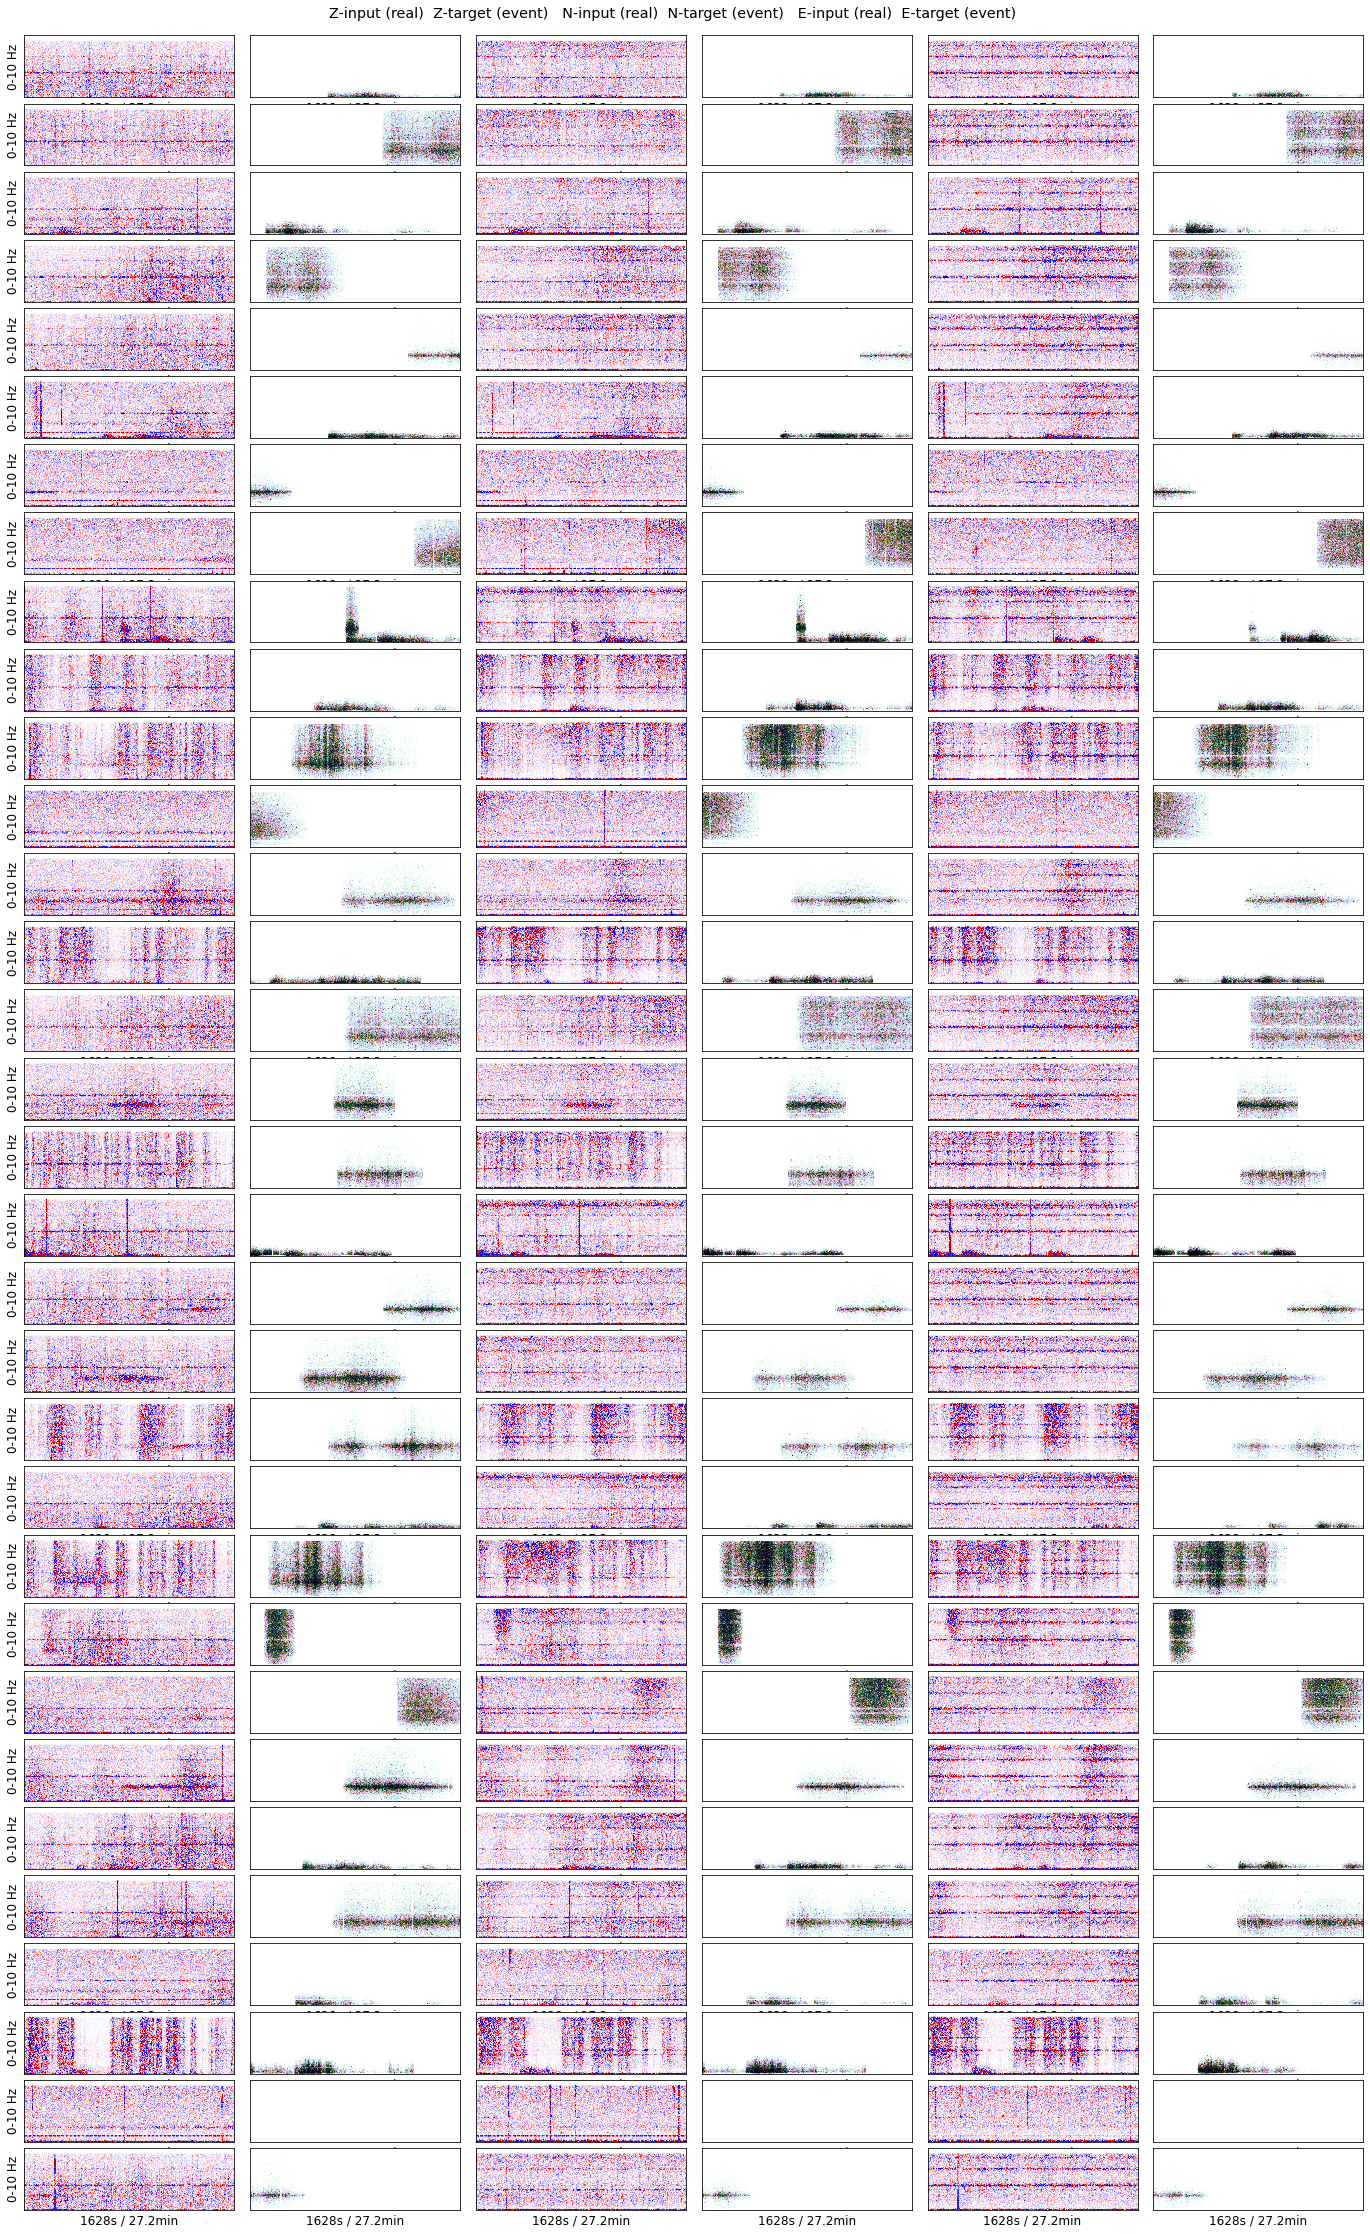

In [8]:
# take a couple of examples (here images=stft coefficients, labels=masks)
for images, labels in train_dataset.take(1):  # only take first element of dataset
  x = images.numpy()
  y = labels.numpy()

def label_off(ax):
  # helper function to remove tick labels in plot
  ax.axes.get_xaxis().set_ticks([])
  ax.axes.get_yaxis().set_ticks([])

# figure specs
num_events = np.shape(x)[0]
fig = plt.figure(figsize=[24, 40])
spec = gridspec.GridSpec(ncols=6, nrows=num_events, figure=fig)#,height_ratios=[1,1,1,1])
spec.update(wspace=0.075, hspace=0.1)

for i in range(num_events):
  f_ax1 = fig.add_subplot(spec[i,0])
  f_ax1.pcolormesh(x[i,:,:,0],vmin=-3,vmax=3,cmap='bwr')
  label_off(f_ax1)
  f_ax1.set_ylabel('0-10 Hz')

  f_ax2 = fig.add_subplot(spec[i,1])
  f_ax2.pcolormesh(y[i,:,:,0],vmin=0,vmax=1,cmap='cubehelix_r')
  label_off(f_ax2)

  f_ax3 = fig.add_subplot(spec[i,2])
  f_ax3.pcolormesh(x[i,:,:,2],vmin=-3,vmax=3,cmap='bwr')
  label_off(f_ax3)

  f_ax4 = fig.add_subplot(spec[i,3])
  f_ax4.pcolormesh(y[i,:,:,2],vmin=0,vmax=1,cmap='cubehelix_r')
  label_off(f_ax4)

  f_ax5 = fig.add_subplot(spec[i,4])
  f_ax5.pcolormesh(x[i,:,:,4],vmin=-3,vmax=3,cmap='bwr')
  label_off(f_ax5)

  f_ax6 = fig.add_subplot(spec[i,5])
  f_ax6.pcolormesh(y[i,:,:,4],vmin=0,vmax=1,cmap='cubehelix_r')
  label_off(f_ax6)

  if i==num_events-1:
    for ax in fig.axes:
      ax.set_xlabel('1628s / 27.2min')

plt.suptitle('Z-input (real)  Z-target (event)   N-input (real)  N-target (event)   E-input (real)  E-target (event)',y=0.89)

## **TRAINING**


Train model and save weights of best model in defined path (+history), with early stopping. With or w/o weight maps.

In [9]:
model_name = 'example_model' # name model
model_path = '/content/gdrive/MyDrive/ML/' # folder were model weights are strored
dir_history = '/content/gdrive/MyDrive/ML/History/' # folder to store training history
use_weight_maps = False # set to True to use weight maps
training_epochs = 20
# define checkpoints 
model_checkpoint_callback = ModelCheckpoint(model_path+model_name+'.h5',  # '-{epoch:04d}.h5'
                             verbose=1, monitor='val_loss',save_best_only=True, mode='auto')

# define eartly stopping and criteria (e.g. validaion loss not improving for 3 epochs by more than 0.001)
callback = EarlyStopping(monitor='val_loss', patience=3,min_delta=0.001,restore_best_weights=True)

start_time = time.time()
with tf.device('/gpu:0'):
  if use_weight_maps: # with class weights map(add_sample_weights)
    history = model.fit(train_dataset.map(add_sample_weights),epochs=training_epochs,steps_per_epoch=len(files_train)/batch_size, verbose=1, batch_size=batch_size, 
                      validation_data=test_dataset.map(add_sample_weights),validation_steps=len(files_test)/batch_size,
                      callbacks=[model_checkpoint_callback,callback])     
  else: # without class weighting
    history = model.fit(train_dataset,epochs=training_epochs,steps_per_epoch=len(files_train)/batch_size, verbose=1, batch_size=batch_size,
                      validation_data=test_dataset,validation_steps=len(files_test)/batch_size,callbacks=[model_checkpoint_callback,callback])

print("--- %s seconds ---" % (time.time() - start_time))

# save model
model_name += date_name()  # get name as current time
dir_history +=model_name  # get dir
np.save(dir_history+'.npy',history.history)  # and save

Epoch 1/20
32/31 [==============================] - ETA: -4s - loss: 0.4108 - binary_crossentropy: 0.4108
Epoch 1: val_loss improved from inf to 0.27381, saving model to /content/gdrive/MyDrive/ML/example_model.h5
31/31 [==============================] - 300s 9s/step - loss: 0.4108 - binary_crossentropy: 0.4108 - val_loss: 0.2738 - val_binary_crossentropy: 0.2738
Epoch 2/20
32/31 [==============================] - ETA: 0s - loss: 0.2620 - binary_crossentropy: 0.2620
Epoch 2: val_loss improved from 0.27381 to 0.20016, saving model to /content/gdrive/MyDrive/ML/example_model.h5
31/31 [==============================] - 43s 1s/step - loss: 0.2620 - binary_crossentropy: 0.2620 - val_loss: 0.2002 - val_binary_crossentropy: 0.2002
Epoch 3/20
32/31 [==============================] - ETA: 0s - loss: 0.1893 - binary_crossentropy: 0.1893
Epoch 3: val_loss improved from 0.20016 to 0.17450, saving model to /content/gdrive/MyDrive/ML/example_model.h5
31/31 [==============================] - 42s 1s/s

### plot loss-epochs using history from training

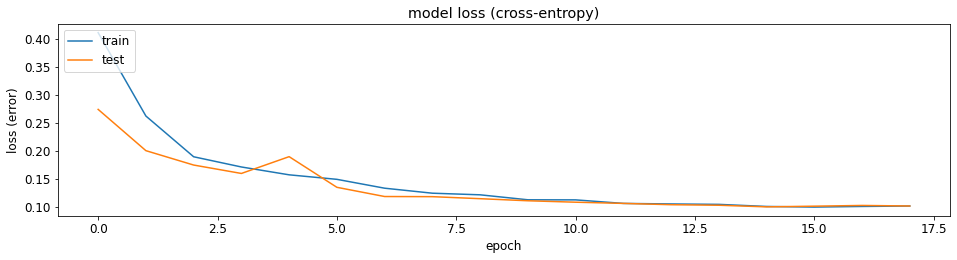

In [10]:
plt.subplot(3,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss (cross-entropy)')
plt.ylabel('loss (error)')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


**Training up to here**

**-------------------------------------------------------------**

**Plotting some results**


In [11]:
# Get some data, random examples
dir_test = path_even_sol_test

files_test = np.array(glob.glob(dir_test + '/*'))
files_test = random.sample(list(files_test), 32)

batch_size = 32 
test_dataset = input_pipeline(files_test,batch_size)

In [12]:
# getting one batch and make prediction 
for images, labels in test_dataset.take(1):  # only take first element of dataset
    x = images.numpy()
    y = labels.numpy()

y_prediction = model.predict(x)  # make prediction

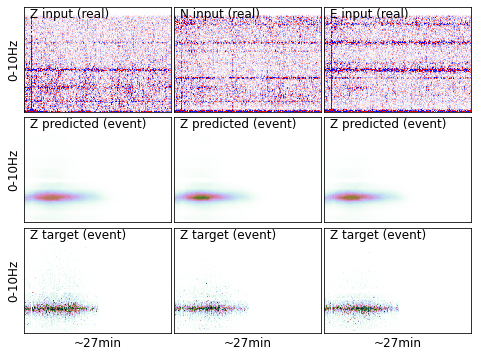

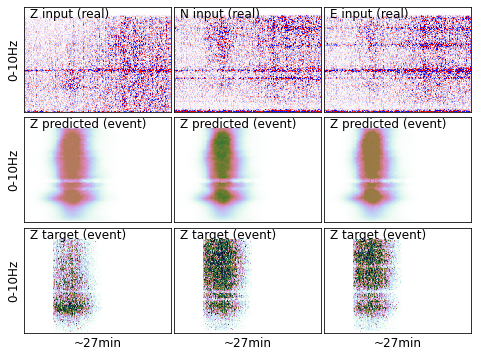

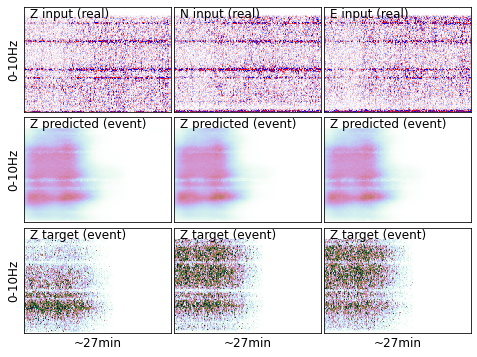

In [13]:
# plot ZNE input, target and predictions for mini batch

num_examples = 3 # len(x)
for example in range(num_examples):
  fig = plt.figure(figsize=[8, 6])
  spec = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)#,height_ratios=[1,1,1,1])
  spec.update(wspace=0.025, hspace=0.05)

  f_ax1 = fig.add_subplot(spec[0])
  f_ax2 = fig.add_subplot(spec[1])
  f_ax3 = fig.add_subplot(spec[2])
  f_ax4 = fig.add_subplot(spec[3])
  f_ax5 = fig.add_subplot(spec[4])
  f_ax6 = fig.add_subplot(spec[5])
  f_ax7 = fig.add_subplot(spec[6])
  f_ax8 = fig.add_subplot(spec[7])
  f_ax9 = fig.add_subplot(spec[8])

  f_ax1.pcolormesh(x[example,:,:,0],vmin=-3,vmax=3,cmap='bwr')
  f_ax2.pcolormesh(x[example,:,:,2],vmin=-3,vmax=3,cmap='bwr')
  f_ax3.pcolormesh(x[example,:,:,4],vmin=-3,vmax=3,cmap='bwr')

  f_ax4.pcolormesh(y_prediction[example,:,:,0],vmin=0,vmax=1,cmap='cubehelix_r')
  f_ax5.pcolormesh(y_prediction[example,:,:,2],vmin=0,vmax=1,cmap='cubehelix_r')
  f_ax6.pcolormesh(y_prediction[example,:,:,4],vmin=0,vmax=1,cmap='cubehelix_r')

  f_ax7.pcolormesh(y[example,:,:,0],vmin=0,vmax=1,cmap='cubehelix_r')
  f_ax8.pcolormesh(y[example,:,:,2],vmin=0,vmax=1,cmap='cubehelix_r')
  f_ax9.pcolormesh(y[example,:,:,4],vmin=0,vmax=1,cmap='cubehelix_r')

  for i, ax in enumerate(fig.axes):
    label_off(ax)
    label = ['Z input (real)','N input (real)','E input (real)','Z predicted (event)','Z predicted (event)',
            'Z predicted (event)','Z target (event)','Z target (event)','Z target (event)'][i]
    ax.text(10,230,label)

  f_ax7.set_xlabel('~27min')
  f_ax8.set_xlabel('~27min')
  f_ax9.set_xlabel('~27min')

  f_ax1.set_ylabel('0-10Hz')
  f_ax4.set_ylabel('0-10Hz')
  f_ax7.set_ylabel('0-10Hz')